In [1]:
!nvidia-smi

Sun Apr  9 23:54:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.0 MB/s eta 0:00:00


Imports

In [5]:
import pandas as pd
# Keras
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Conv2D, GlobalMaxPooling1D
from keras.layers import Embedding
## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

Filepath setup

In [ ]:
INPUT_FOLDER = '/content/drive/MyDrive/Datasets/'
OUTPUT_FOLDER = ''
PATH_TO_YELP_REVIEWS = INPUT_FOLDER + '/yelp_academic_dataset_review.json'
filename = PATH_TO_YELP_REVIEWS

Converting json to csv

In [ ]:
chunks = pd.read_json(filename, lines=True, chunksize=100)
for c in chunks:
  c['text'] = c['text'].replace('\n','').replace('\n\n','').replace('\\n')
  x = pd.DataFrame.from_dict(c)
  x.to_csv('gen.csv', mode='a', index=False, header=False)

Reading CSV in pandas dataframe

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/yelp_review.csv', on_bad_lines='skip', nrows=500000, names=["some_id1", "some_id2", "some_id3", "stars", "useful", "funny", "cool", "text", "date"])

Filtering text and defining labels

In [7]:
df= df.dropna()
df = df[df.stars.apply(lambda x: x !="")]
df = df[df.text.apply(lambda x: x !="")]

labels = df['stars'].map(lambda x : 1 if int(x) > 3 else 0)

Cleaning the data

In [8]:
import nltk 
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

import re
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)    
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

df['text'] = df['text'].map(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Creating sequences (tokenization)

In [9]:
#Create sequence
vocabulary_size = 500000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences, maxlen=100)

GloVe 6B 300d

In [63]:
embeddings_index = dict()
f = open('/content/drive/MyDrive/Datasets/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

GloVe 6B 100d

In [25]:
# embeddings_index = dict()
# f = open('/content/drive/MyDrive/Datasets/glove.6B.100d.txt')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

Word2Vec wiki-news-300d-1M-subword

In [11]:
from gensim.models.keyedvectors import KeyedVectors
embs_path = '/content/drive/MyDrive/Datasets/wiki-news-300d-1M-subword.vec'
embeddings = KeyedVectors.load_word2vec_format(embs_path, binary=False)
dim = embeddings.vectors.shape[1]
pad = np.zeros(dim)
np.random.seed(3)
oov = np.random.uniform(-0.25, 0.25, dim)

W2V Emedding Matrix

In [64]:
embedding_matrix_w2v = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
      try:
        embedding_vector = embeddings[word]
        if embedding_vector is not None:
          embedding_matrix_w2v[index] = embedding_vector
      except:
        embedding_matrix_w2v[index] = oov

GloVe Embedding Matrix

In [65]:
embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [27]:
# embedding_matrix = np.zeros((vocabulary_size, 100))
# for word, index in tokenizer.word_index.items():
#     if index > vocabulary_size - 1:
#         break
#     else:
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[index] = embedding_vector

CNN Model

In [67]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocabulary_size, 300, input_length=100, weights=[embedding_matrix]))
model_cnn.add(Conv1D(filters=10,use_bias=True,input_shape=(100,300),activation='relu',kernel_size=3))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Dropout(.2))
model_cnn.add(Conv1D(filters=10,use_bias=True,input_shape=(100,300),activation='relu',kernel_size=3))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Dropout(.2))
model_cnn.add(Conv1D(filters=10,use_bias=True,input_shape=(100,300),activation='relu',kernel_size=3))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(1,activation='sigmoid'))
model_cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          150000000 
                                                                 
 conv1d_3 (Conv1D)           (None, 98, 10)            9010      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 49, 10)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 49, 10)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 47, 10)            310       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 23, 10)           0         
 1D)                                                  

In [68]:
model_cnn.fit(data, np.array(labels), batch_size = 1024, validation_split=0.2, epochs=10)

Epoch 1/10
391/391 [==============================] - 63s 142ms/step - loss: 0.3753 - acc: 0.8323 - val_loss: 0.2619 - val_acc: 0.8999
Epoch 2/10
391/391 [==============================] - 32s 82ms/step - loss: 0.2723 - acc: 0.8895 - val_loss: 0.2523 - val_acc: 0.9045
Epoch 3/10
391/391 [==============================] - 27s 70ms/step - loss: 0.2527 - acc: 0.8987 - val_loss: 0.2485 - val_acc: 0.9058
Epoch 4/10
391/391 [==============================] - 24s 63ms/step - loss: 0.2388 - acc: 0.9048 - val_loss: 0.2466 - val_acc: 0.9055
Epoch 5/10
391/391 [==============================] - 21s 55ms/step - loss: 0.2273 - acc: 0.9098 - val_loss: 0.2442 - val_acc: 0.9040
Epoch 6/10
391/391 [==============================] - 20s 51ms/step - loss: 0.2157 - acc: 0.9151 - val_loss: 0.2463 - val_acc: 0.9034
Epoch 7/10
391/391 [==============================] - 22s 56ms/step - loss: 0.2059 - acc: 0.9189 - val_loss: 0.2448 - val_acc: 0.9028
Epoch 8/10
391/391 [==============================] - 20s 51m

LSTM Model

In [28]:
model = Sequential()
model.add(Embedding(vocabulary_size, 100, input_length=300, weights=[embedding_matrix], trainable=True))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(24, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          50000000  
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 24)                2424      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 50,082,849
Trainable params: 50,082,849
Non-trainable params: 0
_________________________________________________________________


In [72]:
history = model.fit(data, np.array(labels), batch_size = 1024, validation_split=0.2, epochs=10)

Epoch 1/10
391/391 [==============================] - 201s 515ms/step - loss: 0.2202 - accuracy: 0.9097 - val_loss: 0.2015 - val_accuracy: 0.9178
Epoch 2/10
391/391 [==============================] - 196s 500ms/step - loss: 0.2104 - accuracy: 0.9143 - val_loss: 0.2079 - val_accuracy: 0.9188
Epoch 3/10
391/391 [==============================] - 197s 504ms/step - loss: 0.2021 - accuracy: 0.9182 - val_loss: 0.2099 - val_accuracy: 0.9197
Epoch 4/10
391/391 [==============================] - 196s 501ms/step - loss: 0.1944 - accuracy: 0.9213 - val_loss: 0.2031 - val_accuracy: 0.9201
Epoch 5/10
391/391 [==============================] - 220s 563ms/step - loss: 0.1874 - accuracy: 0.9243 - val_loss: 0.2070 - val_accuracy: 0.9208
Epoch 6/10
391/391 [==============================] - 194s 495ms/step - loss: 0.1798 - accuracy: 0.9277 - val_loss: 0.2037 - val_accuracy: 0.9208
Epoch 7/10
391/391 [==============================] - 195s 499ms/step - loss: 0.1732 - accuracy: 0.9306 - val_loss: 0.2197 -

Metrics

In [73]:
metrics_df = pd.DataFrame(history.history)

In [74]:
metrics_df

,loss,accuracy,val_loss,val_accuracy
0,0.220162,0.909680,0.201473,0.91780
1,0.210449,0.914325,0.207895,0.91879
2,0.202054,0.918172,0.209948,0.91973
3,0.194365,0.921290,0.203130,0.92011
4,0.187378,0.924272,0.207039,0.92082
5,0.179763,0.927737,0.203691,0.92085
6,0.173151,0.930568,0.219734,0.91707
7,0.166574,0.933370,0.212255,0.91751
8,0.160254,0.935685,0.233708,0.91764
9,0.153540,0.938752,0.231463,0.91793


Plot

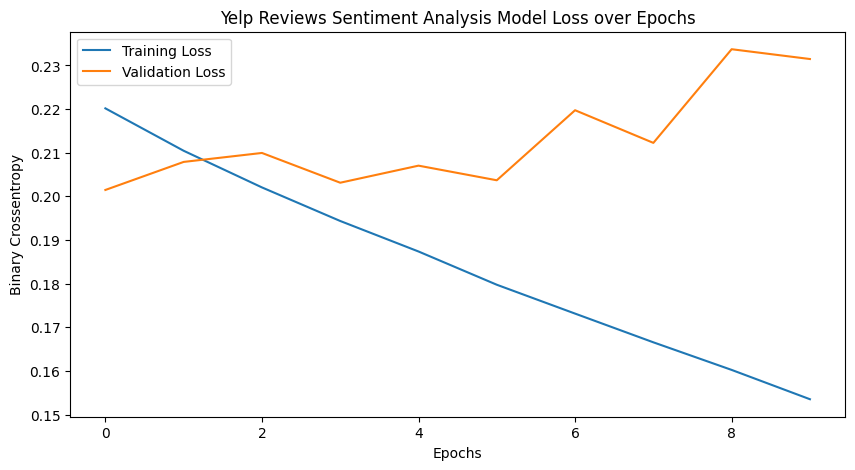

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('Yelp Reviews Sentiment Analysis Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

Testing

In [57]:
def test(review):
  review = tokenizer.texts_to_sequences(review)
  review = pad_sequences(review, maxlen=100, dtype='int32', value=0)
  sentiment = model.predict(review, batch_size=1, verbose=2)[0]
  print(sentiment)
  if(sentiment < 0.5):
    print("Negative")
  else:
    print("Positive")

In [60]:
review = ['This is a good restaurant to eat, however the service was slow!']
test(review)

1/1 - 0s - 45ms/epoch - 45ms/step
[0.35082385]
Negative


In [62]:
review = ['This restaurant had an okayish vibe but the food was tasty!']
test(review)

1/1 - 0s - 63ms/epoch - 63ms/step
[0.7238563]
Positive
